COMPUTER ASSIGNMENTS 4 AND 5

GROUP1: YASAMAN, OZAN, and FIROOZ

In [1]:
import numpy as np
from numpy import linalg as LA
import os
import sys
import copy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

First, I will create the problem, which contains loading data and distributing it among agents followed by computing the valua and gradient of logistic regression loss. Since the goal of the assignment is the implementation of decentralized gradient and subgradient methods, I change the problem to binary classification of mnist dataset with two digits and logistic regression cost. 

In [5]:
class LR_L2(object):
    def __init__(self, n_agent, class1 = 2, class2 = 6, train = 12000, balanced = True, limited_labels = False, regularization = True, lamda = None ):
        self.class1 = class1
        self.class2 = class2
        self.train = train
        self.limited_labels = limited_labels
        self.n = n_agent
        self.balanced = balanced
        self.X_train, self.Y_train, self.X_test, self.Y_test = self.load_data()
        self.N = len(self.X_train)            ## total number of data samples
        if balanced == False:
            self.split_vec = np.sort(np.random.choice(np.arange(1,self.N),self.n-1, replace = False ))
        self.X, self.Y, self.data_distr = self.distribute_data()
        self.p = len(self.X_train[0])         ## dimension of the feature
        if regularization:
            if lamda == None:
                self.reg = 1/self.N
            else:
                self.reg = lamda
        else:
            self.reg = 0.0

        self.dim = self.p                     ## dimension of the feature
        # self.L, self.kappa = self.smooth_scvx_parameters()
        self.b = int(self.N/self.n)           ## average local samples

    def load_data(self):
        data = np.load('mnist.npz', allow_pickle=True)
        X = data['X']
        y = data['y']

        y = y.astype(int)
        print( 'data initialized' )

        ## append 1 to the end of all data points
        X = np.append(X, np.ones((X.shape[0],1)), axis = 1)

        ## data normalization: each data is normalized as a unit vector
        X = X / LA.norm(X,axis = 1)[:,None]

        ## select corresponding classes
        X_C1_C2 = X[ (y == self.class1) | (y == self.class2) ]
        y_C1_C2 = y[ (y == self.class1) | (y == self.class2) ]
        y_C1_C2[ y_C1_C2 == self.class1 ] = 1
        y_C1_C2[ y_C1_C2 == self.class2 ] = -1
        X_train, X_test = X_C1_C2[ : self.train], X_C1_C2[ self.train : ]
        Y_train, Y_test = y_C1_C2[ : self.train], y_C1_C2[ self.train : ]

        if self.limited_labels == True:
            permutation = np.argsort(Y_train)
            X_train = X_train[permutation]
            Y_train = np.sort(Y_train)

        return X_train.copy(), Y_train.copy(), X_test.copy(), Y_test.copy()

    def distribute_data(self):
        if self.balanced == True:
           X = np.array( np.split( self.X_train, self.n, axis = 0 ) )
           Y = np.array( np.split( self.Y_train, self.n, axis = 0 ) )
        if self.balanced == False:   ## random distribution
           X = np.array( np.split(self.X_train, self.split_vec, axis = 0) )
           Y = np.array( np.split(self.Y_train, self.split_vec, axis = 0 ) )
        data_distribution = np.array([ len(_) for _ in X ])
        return X, Y, data_distribution

    def F_val(self, theta):           ##  objective function value at theta
        if self.balanced == True:
            f_val = np.sum( np.log( np.exp( np.multiply(-self.Y_train,\
                                                    np.matmul(self.X_train,theta)))+1 ) )/self.N
            reg_val = (self.reg/2) * (LA.norm(theta) ** 2)
            return f_val + reg_val
        if self.balanced == False:
            temp1 = np.log( np.exp( np.multiply(-self.Y_train,\
                              np.matmul(self.X_train,theta)) ) + 1 )
            temp2 = np.split(temp1, self.split_vec)
            f_val = 0
            for i in range(self.n):
                f_val += np.sum(temp2[i])/self.data_distr[i]
            reg_val = (self.reg/2) * (LA.norm(theta) ** 2)
            return f_val/self.n + reg_val


    def localgrad(self, theta, idx, j = None ):  ## idx is the node index, j is local sample index
        if j == None:                 ## local full batch gradient
            temp1 = np.exp( np.matmul(self.X[idx],theta[idx]) * (-self.Y[idx])  )
            temp2 = ( temp1/(temp1+1) ) * (-self.Y[idx])
            grad = self.X[idx] * temp2[:,np.newaxis]
            return np.sum(grad, axis = 0)/self.data_distr[idx] + (self.reg)*theta[idx]
            # return np.sum(grad, axis = 0)/self.data_distr[idx] + (self.reg/self.n)*theta[idx]
        else:                         ## local stochastic gradient
            temp = np.exp(self.Y[idx][j]*np.inner(self.X[idx][j], theta[idx]))
            grad_lr = -self.Y[idx][j]/(1+temp) * self.X[idx][j]
            grad_reg = self.reg * theta[idx]
            grad = grad_lr + grad_reg
            # grad = grad_lr + grad_reg/self.n
            return grad

    def networkgrad(self, theta, idxv = None):  ## network stochastic/batch gradient
        grad = np.zeros( (self.n,self.p) )
        if idxv is None:                        ## full batch
            for i in range(self.n):
                grad[i] = self.localgrad(theta , i)
            return grad
        else:                                   ## stochastic gradient: one sample
            for i in range(self.n):
                grad[i] = self.localgrad(theta, i, idxv[i])
            return grad

    def grad(self, theta, idx = None): ## centralized stochastic/batch gradient
        if idx == None:                ## full batch
            if self.balanced == True:
                temp1 = np.exp( np.matmul(self.X_train,theta) * (-self.Y_train)  )
                temp2 = ( temp1/(temp1+1) ) * (-self.Y_train)
                grad = self.X_train * temp2[:,np.newaxis]
                return np.sum(grad, axis = 0)/self.N + self.reg * theta 
            if self.balanced == False:
                return np.sum( self.networkgrad(np.tile(theta,(self.n,1)))\
                              , axis = 0 )/self.n
        else:
            if self.balanced == True:
                temp = np.exp(self.Y_train[idx]*np.inner(self.X_train[idx], theta))
                grad_lr = -self.Y_train[idx]/(1+temp) * self.X_train[idx]
                grad_reg = self.reg * theta
                grad = grad_lr + grad_reg
                return grad
            if self.balanced == False:
                sys.exit( 'data distribution is not balanced !!!' )


In [72]:
seed = 4
np.random.seed(seed)

n = 10
num_train = 5000
lamdaa = 1/num_train
#### instantiate the problem class
lr_0 = LR_L2(n, limited_labels = False, balanced = True, train = num_train, regularization = True, lamda = lamdaa)  


data initialized


PART A and B

Defining optimization algorithms: decentralized gradient descent and descentralized subgradient descent.
I have also implemented the centralized gradient descent to find the optimal value for the weitghts. Therefore, we are able to compute the optimality gap as loss(weight_iteration)-loss(optimal_weights). 

To robustify the algorithms on communication noise, we came with the idea of adding redundancy (more information) in each iterations. In this regards, in each iteration, we will communicate each message several times and will use their average in the update rules of the algorithm. This idea will reduce the noise variance hopefully, which we will investigate in the following. 

In [113]:
### Centralized gradient descent
def CGD(prd,learning_rate,K,theta_0):
    theta = [theta_0]
    for k in range(K):
        theta.append( theta[-1] - learning_rate * prd.grad(theta[-1]) )
    theta_opt = theta[-1]
    F_opt = prd.F_val(theta[-1])
    return theta_opt, F_opt

### decentralized subgradient descent: B is the matrix containing the weights of communication links. 
def DSD(prd,B,learning_rate,K,theta_0, p, R):
    theta = [cp.deepcopy( theta_0 )]
    grad  = prd.networkgrad( theta[-1] )
    F_value = [prd.F_val(np.mean(theta[-1], axis=0))]
    for k in range(K):
        add_noise = np.random.binomial(1,p)
        if add_noise:
            noise = R*np.random.randn(prd.n,785)
            noisy_theta = theta[-1] + noise
            theta.append( np.matmul( B, noisy_theta ) - learning_rate * grad )
        else:
            theta.append( np.matmul( B, theta[-1] ) - learning_rate * grad )
        grad = prd.networkgrad( theta[-1] )
        F_value.append(prd.F_val(np.mean(theta[-1], axis=0)))
    return theta, F_value



def robust_DSD(prd,B,learning_rate,K,theta_0, p, R, num_communications=1):
    theta = [cp.deepcopy( theta_0 )]
    grad  = prd.networkgrad( theta[-1] )
    F_value = [prd.F_val(np.mean(theta[-1], axis=0))]
    for k in range(K):

        noise = np.zeros((prd.n,785))
        counter = 0
        for kk in range(num_communications):
            add_noise = np.random.binomial(1,p)
            if add_noise:
                counter += 1
                noise += R*np.random.randn(prd.n,785)

        if counter == 0:
            counter = 1

        noisy_theta = theta[-1] + noise/counter
        theta.append( np.matmul( B, noisy_theta ) - learning_rate * grad )
           
        grad = prd.networkgrad( theta[-1] )
        F_value.append(prd.F_val(np.mean(theta[-1], axis=0)))
    return theta, F_value


### decentralized gradient descent (master/worker)
def DGD(prd,learning_rate,K,theta_0, p=0, R=0, robust=False, num_communication=1):
    if robust:
        R = R/num_communication
    theta = [cp.deepcopy(theta_0)]
    add_noise = np.random.binomial(1,p)
    if add_noise:
        noise = R*np.random.randn(prd.n,785)
        theta_tile = np.tile(theta[-1],(prd.n,1)) + noise
    else:
        theta_tile = np.tile(theta[-1],(prd.n,1)) 
    grad_workers  = prd.networkgrad( theta_tile ) # copy master variable and compute gradients
    grad = np.mean(grad_workers, axis=0) #compute average of gradients at master node
    F_value = [prd.F_val(theta[-1])]
    for k in range(K):
        theta.append(theta[-1]-learning_rate*grad)
        add_noise = np.random.binomial(1,p)
        if add_noise:
            noise1 = R*np.random.randn(prd.n,785)
            theta_tile = np.tile(theta[-1],(prd.n,1)) + noise1
            noise2 = R*np.random.randn(grad_workers.shape[0],grad_workers.shape[1])
            grad_workers = prd.networkgrad( theta_tile ) + noise2 
        else:
            theta_tile = np.tile(theta[-1],(prd.n,1))
            grad_workers = prd.networkgrad( theta_tile )

        grad = np.mean(grad_workers, axis=0)
        F_value.append(prd.F_val(theta[-1]))
    return theta, F_value


Compute the weight matrix for the two-star graph topology you mentioned as I-L/c, where L is the laplacian matrix, and I is the Identity matrix. c is a constant which is required in decentralized algorithms. 

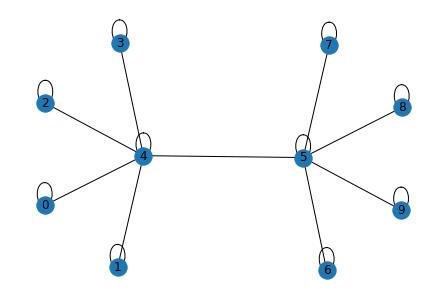

In [88]:
L = np.zeros((10,10))
L[0,0] = 1
L[1,1] = 1 
L[2,2] = 1
L[3,3] = 1
L[4,4] = 5
L[5,5] = 5
L[6,6] = 1
L[7,7] = 1
L[8,8] = 1
L[9,9] = 1

L[0,4] = -1
L[4,0] = -1
L[1,4] = -1
L[4,1] = -1
L[2,4] = -1
L[4,2] = -1
L[3,4] = -1
L[4,3] = -1
L[4,5] = -1
L[5,4] = -1
L[5,6] = -1
L[6,5] = -1
L[5,7] = -1
L[7,5] = -1
L[5,8] = -1
L[8,5] = -1
L[5,9] = -1
L[9,5] = -1

# Create a graph from the Laplacian matrix
G = nx.from_numpy_matrix(-L)
# Plot the graph
nx.draw(G, with_labels=True)
plt.show()

Now, the decentralized graph is created, and the algorithms are implemented. we have to create several plots to characterize the convergence of DSD and DGD algorithm (plus their robust versions) against p and R values. 

Text(0.5, 1.0, 'optimality gap plot: convergence to the optimal solution')

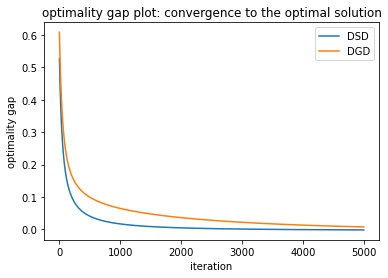

In [94]:
theta_opt, F_opt = CGD(lr_0, 1.5, 5000, np.random.randn(785))
theta_DSD, f_DSD = DSD(lr_0, np.identity(10)-L/5, 1, 5000, np.random.randn(10,785), p=0, R=0) 
theta_DGD, f_DGD = DGD(lr_0, 1, 5000, np.random.randn(785), p=0, R=0, robust=False, num_communication=1) 

# theta_DSD, f_DSD = robust_DSD(lr_0, np.identity(10)-L/5, 0.1, 500, np.random.randn(10,785), p=.5, R=0.12, num_communications=5) 

plt.figure()
plt.plot(f_DSD-F_opt)
plt.plot(f_DGD-F_opt)
plt.xlabel('iteration')
plt.ylabel('optimality gap')
plt.legend(('DSD','DGD'))
plt.title('optimality gap: convergence to the optimal solution')

The above plot indicates that DSD is faster than DGD (master/worker setup) in terms of number of iterations. 
Now lets check the chracterisitics:

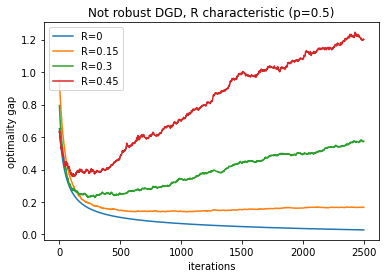

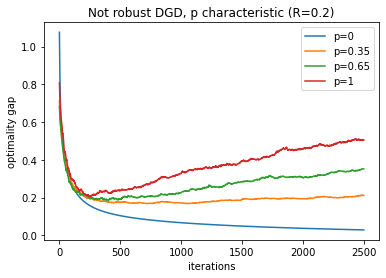

In [103]:
num_iter = 2500

_, f_DGD_p0 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.,   R=0.2, robust=False, num_communication=1) 
_, f_DGD_p1 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.35, R=0.2, robust=False, num_communication=1) 
_, f_DGD_p2 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.65, R=0.2, robust=False, num_communication=1) 
_, f_DGD_p3 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=1.,   R=0.2, robust=False, num_communication=1) 

_, f_DGD_r0 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.0,  robust=False, num_communication=1) 
_, f_DGD_r1 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.15, robust=False, num_communication=1) 
_, f_DGD_r2 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.3,  robust=False, num_communication=1) 
_, f_DGD_r3 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.45, robust=False, num_communication=1) 

plt.figure()
plt.plot(f_DGD_r0-F_opt)
plt.plot(f_DGD_r1-F_opt)
plt.plot(f_DGD_r2-F_opt)
plt.plot(f_DGD_r3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Not robust DGD, R characteristic (p=0.5)')
plt.legend(('R=0','R=0.15', 'R=0.3', 'R=0.45'))


plt.figure()
plt.plot(f_DGD_p0-F_opt)
plt.plot(f_DGD_p1-F_opt)
plt.plot(f_DGD_p2-F_opt)
plt.plot(f_DGD_p3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Not robust DGD, p characteristic (R=0.2)')
plt.legend(('p=0','p=0.35', 'p=0.65', 'p=1'))

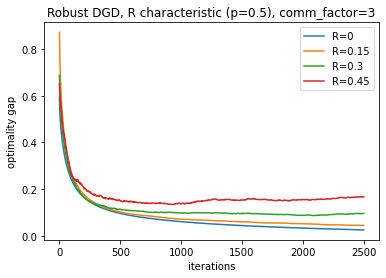

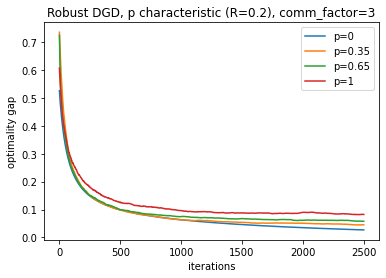

In [110]:
num_iter = 2500
comm_factor = 3
_, f_DGD_p0 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.,   R=0.2, robust=True, num_communication=comm_factor) 
_, f_DGD_p1 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.35, R=0.2, robust=True, num_communication=comm_factor) 
_, f_DGD_p2 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.65, R=0.2, robust=True, num_communication=comm_factor) 
_, f_DGD_p3 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=1.,   R=0.2, robust=True, num_communication=comm_factor) 

_, f_DGD_r0 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.0,  robust=True, num_communication=comm_factor) 
_, f_DGD_r1 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.15, robust=True, num_communication=comm_factor) 
_, f_DGD_r2 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.3,  robust=True, num_communication=comm_factor) 
_, f_DGD_r3 = DGD(lr_0, 1, num_iter, np.random.randn(785), p=0.5, R=0.45, robust=True, num_communication=comm_factor) 

plt.figure()
plt.plot(f_DGD_r0-F_opt)
plt.plot(f_DGD_r1-F_opt)
plt.plot(f_DGD_r2-F_opt)
plt.plot(f_DGD_r3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Robust DGD, R characteristic (p=0.5), comm_factor=3')
plt.legend(('R=0','R=0.15', 'R=0.3', 'R=0.45'))

plt.figure()
plt.plot(f_DGD_p0-F_opt)
plt.plot(f_DGD_p1-F_opt)
plt.plot(f_DGD_p2-F_opt)
plt.plot(f_DGD_p3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Robust DGD, p characteristic (R=0.2), comm_factor=3')
plt.legend(('p=0','p=0.35', 'p=0.65', 'p=1'))

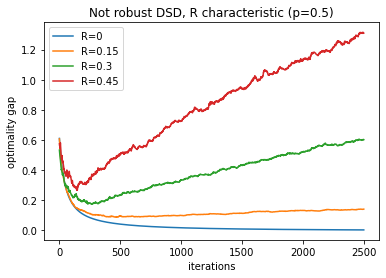

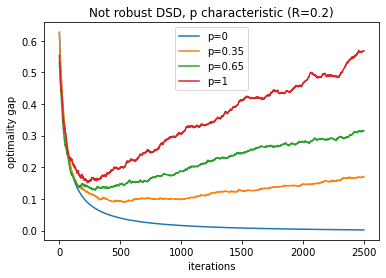

In [117]:
num_iter = 2500
comm_factor = 3
B = np.identity(10)-L/5
_, f_DGD_p0 = DSD(lr_0, B, 1, num_iter, np.random.randn(10,785), p=0.,   R=0.2) 
_, f_DGD_p1 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.35, R=0.2) 
_, f_DGD_p2 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.65, R=0.2) 
_, f_DGD_p3 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=1.,   R=0.2) 

_, f_DGD_r0 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.0) 
_, f_DGD_r1 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.15) 
_, f_DGD_r2 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.3) 
_, f_DGD_r3 = DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.45) 

plt.figure()
plt.plot(f_DGD_r0-F_opt)
plt.plot(f_DGD_r1-F_opt)
plt.plot(f_DGD_r2-F_opt)
plt.plot(f_DGD_r3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Not robust DSD, R characteristic (p=0.5)')
plt.legend(('R=0','R=0.15', 'R=0.3', 'R=0.45'))

plt.figure()
plt.plot(f_DGD_p0-F_opt)
plt.plot(f_DGD_p1-F_opt)
plt.plot(f_DGD_p2-F_opt)
plt.plot(f_DGD_p3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Not robust DSD, p characteristic (R=0.2)')
plt.legend(('p=0','p=0.35', 'p=0.65', 'p=1'))

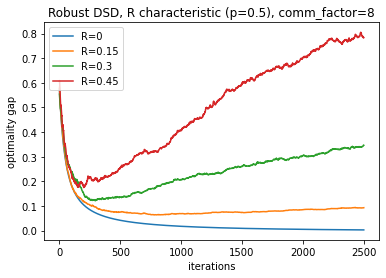

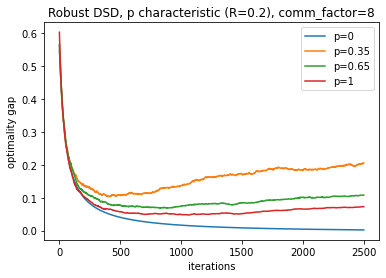

In [118]:
num_iter = 2500
comm_factor = 8
_, f_DGD_p0 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.,   R=0.2, num_communications=comm_factor) 
_, f_DGD_p1 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.35, R=0.2, num_communications=comm_factor) 
_, f_DGD_p2 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.65, R=0.2, num_communications=comm_factor) 
_, f_DGD_p3 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=1.,   R=0.2, num_communications=comm_factor) 

_, f_DGD_r0 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.0,  num_communications=comm_factor) 
_, f_DGD_r1 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.15, num_communications=comm_factor) 
_, f_DGD_r2 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.3,  num_communications=comm_factor) 
_, f_DGD_r3 = robust_DSD(lr_0, B,  1, num_iter, np.random.randn(10,785), p=0.5, R=0.45, num_communications=comm_factor) 

plt.figure()
plt.plot(f_DGD_r0-F_opt)
plt.plot(f_DGD_r1-F_opt)
plt.plot(f_DGD_r2-F_opt)
plt.plot(f_DGD_r3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Robust DSD, R characteristic (p=0.5), comm_factor=8')
plt.legend(('R=0','R=0.15', 'R=0.3', 'R=0.45'))

plt.figure()
plt.plot(f_DGD_p0-F_opt)
plt.plot(f_DGD_p1-F_opt)
plt.plot(f_DGD_p2-F_opt)
plt.plot(f_DGD_p3-F_opt)
plt.xlabel('iterations')
plt.ylabel('optimality gap')
plt.title('Robust DSD, p characteristic (R=0.2), comm_factor=8')
plt.legend(('p=0','p=0.35', 'p=0.65', 'p=1'))

Conclusions: 

1. DSD converges faster than DGD, which shows decentralized setup is better than master/worker setup.

2. by adding noise, the algorithms were more sensitive to step-size (so we have to be careful about it)

3. The robustification idea works properly and the loss function decrease became more smooth. Moreover, larger values of variance can be handled by the robustified algorithms.

4. From figures, we can conclude both the algorithm are sensitive to communication noise represented by p and R values. When we increase the probability of messages corrupted by noise defined by p, the oscilation starts in the loss function plot, and for high probabilities, there is a possibility that the algorithm diverges. 
We observed the same situation by increasing the variance of the noise represented by R. for large values of the noise variance, The loss function start to increase at some iterations and generally oscilates. Again for very large values, the algorithm may start to diverge. 






SOLUTION PART C: 

It is obvious that in the master/worker structure, we have to protect the master node, since hallf of the communications are from master node to the worker nodes. So, by protecting the master node, we will reduce the impact of noise very well (I do not think that the relation is linear: for example the number of sufficient iterations to achienve an acceptable accuracy will not decrease by half although we are protecting half of the sent messages corrupted by noise, but surely, we will reach to that accuracy with fewer iteration if we protect the master node.)

For the decentralized subgradient algorithm which is over a decentealized communication network, it depends on the communication graph for deciding which nodes we have to protect. In this assignment, since the communication graph is two-star network, the two nodes which are the centers of each star should be protected since most of the communication is related to these two nodes. 

Moreover, in the robust algorithm, we can assign higher weights to the protected nodes to increase the performance of the robust algorithm. 

COMPUTER ASSIGNMENT 5: 

Part A: we have decentralized GD with 10 workers. Therefore, each iteration contains 20 communications. The loss will decrease in the same way as before, only the x_axis values shoule be multiplied by 20


Part B: Due to time limitations we were not able to implement ADMM

Part C: I think if we were able to implement part B, we could see that ADMM converges faster with respect to the number of communications. 

Now we should think about some ideas regarding how to reduce the number of communications since the communication is costly for large-scale problems. 

1. we have to define a information theoric metric to find the similarity of local objective function. Then, if two nodes are similar to each other, but the cost of communication for one ia much higher than the other one, we can freeze that node for several iteration (for exampole that node sends every 10 iterations)

2. we have to find the best communication graph; dense graphs are not always the best communication networks. As far as I know, some graphs have higher smallest eigenvalues, which shows better connectivity, so we have to try to communicate over those networks

3. online sparse graph learning, this one seems very intersting topic to me, and I would like to explore it more. 

In [ ]:
def DSD(prd,B,learning_rate,K,theta_0, p, R):
    theta = [cp.deepcopy( theta_0 )]
    grad  = prd.networkgrad( theta[-1] )
    F_value = [prd.F_val(np.mean(theta[-1], axis=0))]
    for k in range(K):
        add_noise = np.random.binomial(1,p):
        if add_noise:
            noise = R*np.random.randn(prd.n,785)
            noisy_theta = theta[-1] + noise
            theta.append( np.matmul( B, noisy_theta ) - learning_rate * grad )
        else:
            theta.append( np.matmul( B, theta[-1] ) - learning_rate * grad )
        grad = prd.networkgrad( theta[-1] )
        F_value.append(prd.F_val(np.mean(theta[-1], axis=0)))
    return theta, F_value